## CA4021 Assignment 1 - Random Forest and AutoML

In this notebook, I use the Pima Indians diabetes dataset to build machine learning models to predict whether patients have diabetes or not. This is done using both AutoML and Ensemble methods (Random Forest).

I will use **roc-AUC** and **accuracy scores** as metrics for evaluating model performance.

<br>
Data: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

The dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases in the United states. It's objective is to use diagnostic measurements for predicting whether or not a patient has diabetes. The data is selected from a larger database using the following constrains; 

Patients are:
- Female
- At least 21 years old
- Of Pima Indain Heritage

<br>

Original paper:

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the
ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the
Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer
Society Press.

Notebook authored by Joseph Oluwasanya

### 1. Importing libraries and data

In [1]:
# Data Wrangling & Visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Modelling
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from pycaret.classification import *

seed = 42
    

In [2]:
df = pd.read_csv('../data/diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
response = 'Outcome'
predictors = [col for col in df.columns if col != response]
predictors

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### 2. Data Cleaning & Analysis

The presence of 0's as values for variables such as Insulin, BloodPressure, and Skin Thickness seems counterintuitive. These could appear for many reasons, and due to the large proportion of data with these values (E.g., ~50% with 0 Insulin), dropping all those rows could be problematic. I dealt with this in the following manner:

- drop rows with 0 BMI, glucose, or blood pressure (these made up a small number of rows)
- Keep rows with 0 skin thickness or insulin

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# no missing values
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# % of the data with value 0 for each variable
np.round(((df == 0).sum(axis=0) / df.shape[0])*100, 2)

Pregnancies                 14.45
Glucose                      0.65
BloodPressure                4.56
SkinThickness               29.56
Insulin                     48.70
BMI                          1.43
DiabetesPedigreeFunction     0.00
Age                          0.00
Outcome                     65.10
dtype: float64

In [8]:
(df == 0).sum(axis=0)

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [9]:
# filter out rows with 0 blood pressure, BMI, or glucose
df_aux = df[(df['BloodPressure'] != 0) & (df['BMI'] != 0) & (df['Glucose'] != 0)]
print('Dropped', df.shape[0] - df_aux.shape[0], 'rows')
df = df_aux.copy()

Dropped 44 rows


Histogram and density plot of Pregnancies


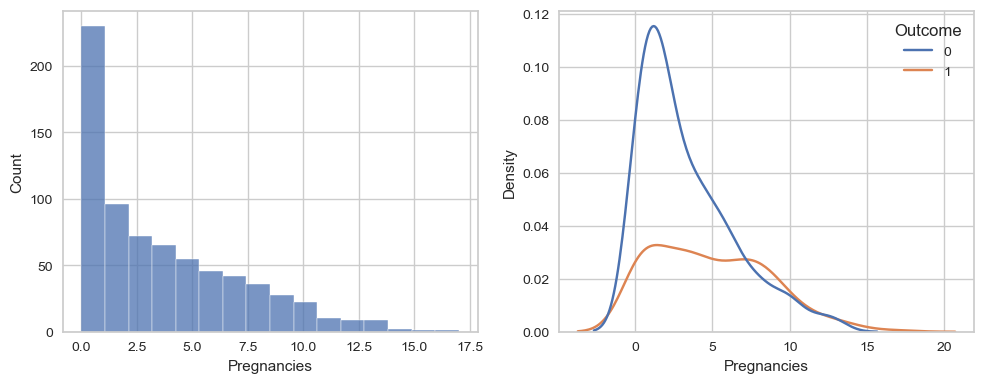

Histogram and density plot of Glucose


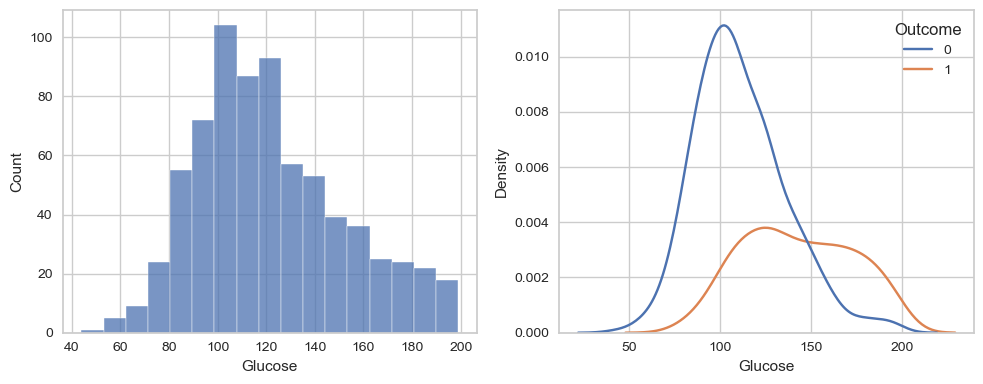

Histogram and density plot of BloodPressure


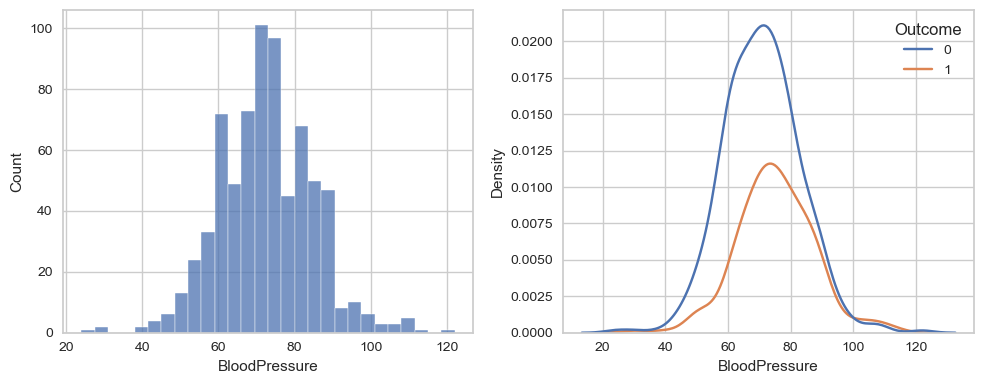

Histogram and density plot of SkinThickness


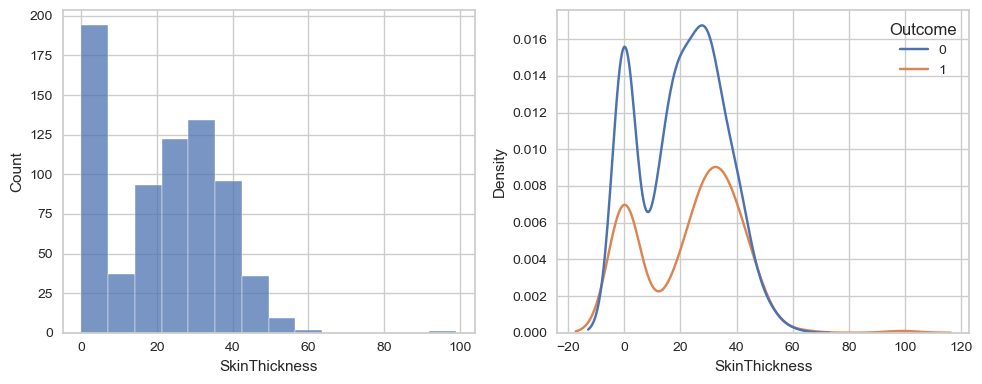

Histogram and density plot of Insulin


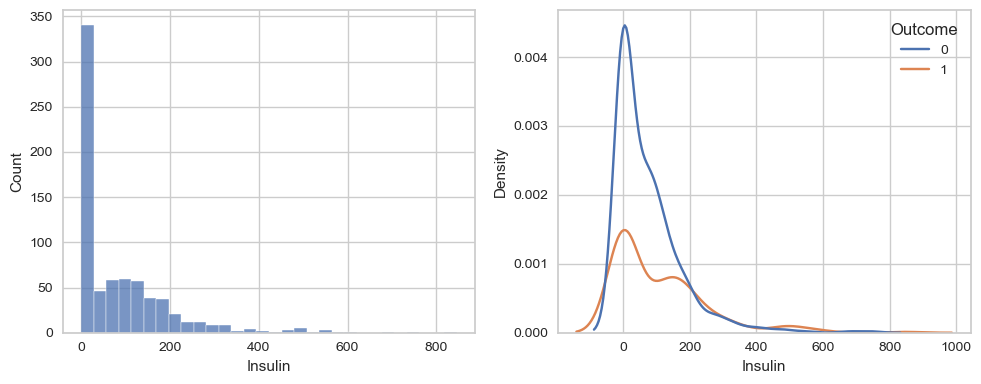

Histogram and density plot of BMI


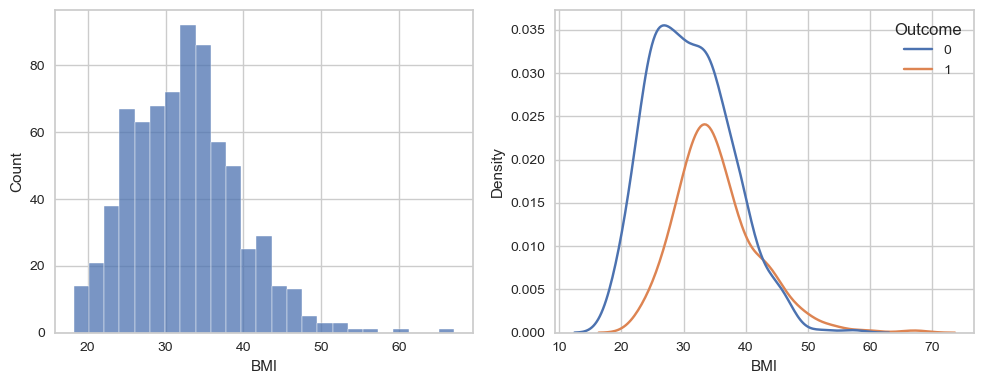

Histogram and density plot of DiabetesPedigreeFunction


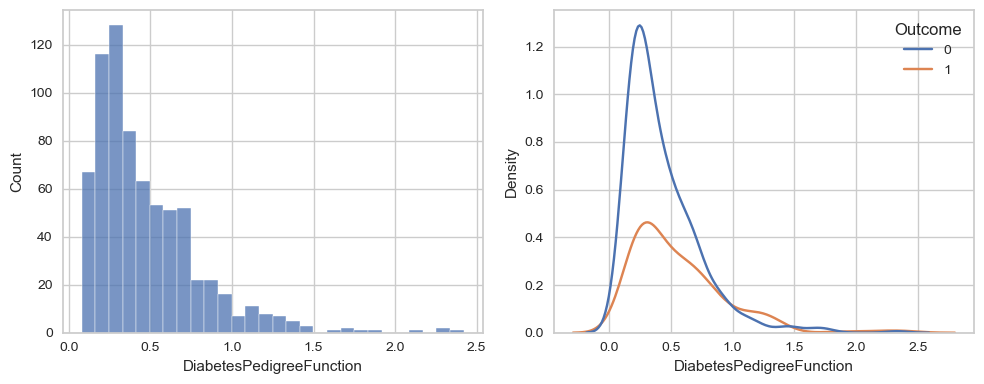

Histogram and density plot of Age


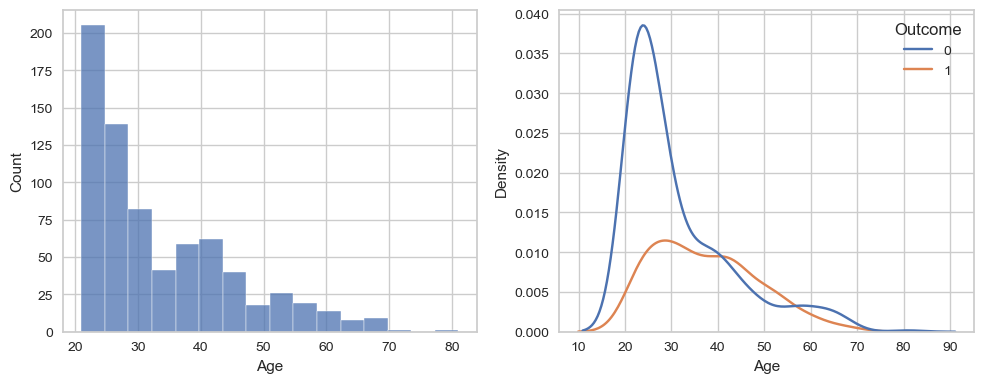

In [10]:
# all the features are numeric, so we will check the distributions using histograms. 
# We also check the difference in distribution between the response groups
sns.set_style('whitegrid')
sns.set_palette('deep')

for f in predictors:
    print("Histogram and density plot of", f)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    sns.histplot(x=f, data=df, ax = ax1)
    sns.kdeplot(x=f, data=df, hue=response, ax = ax2)
    
    plt.tight_layout()
    plt.show()

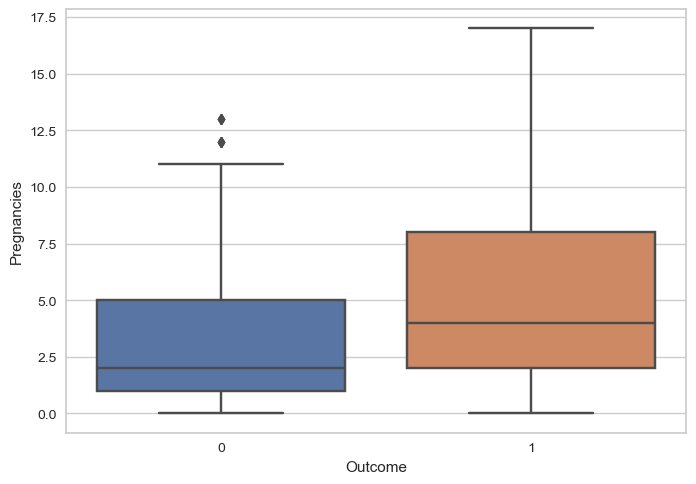

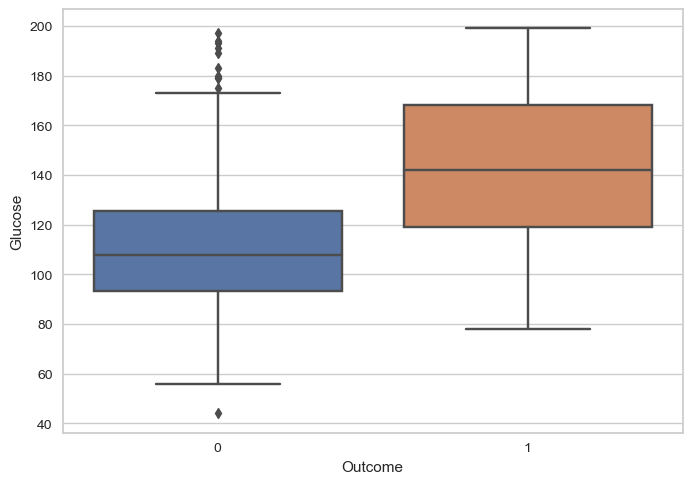

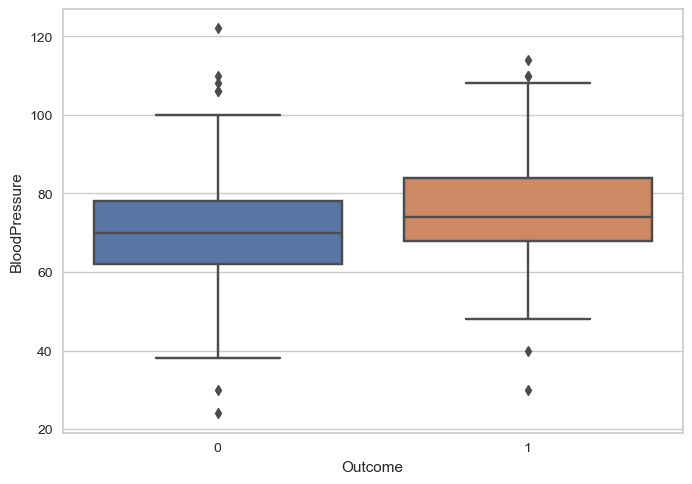

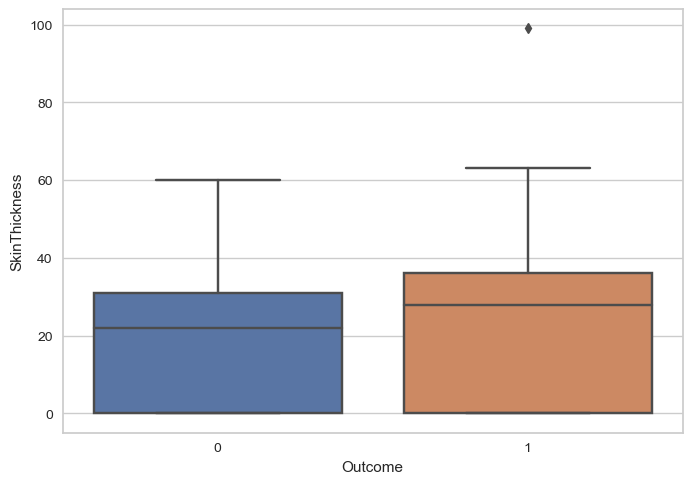

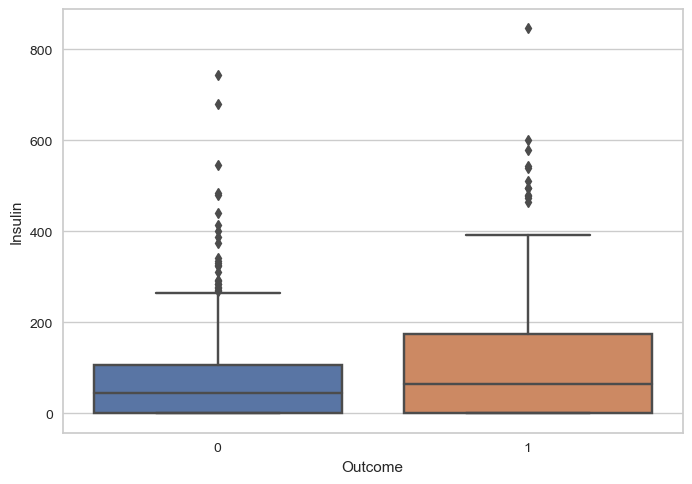

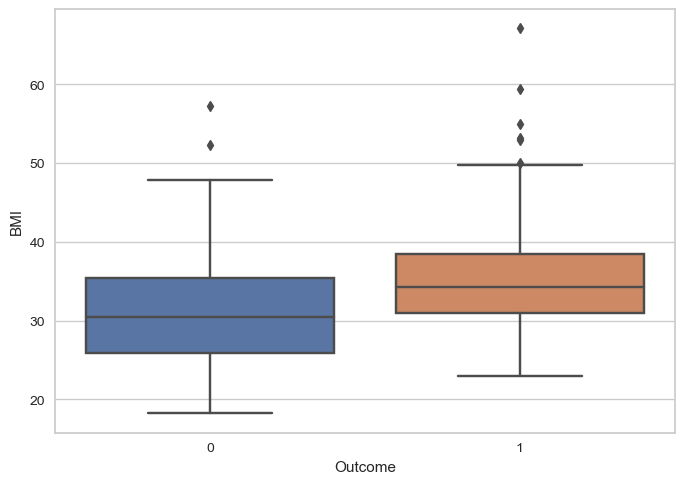

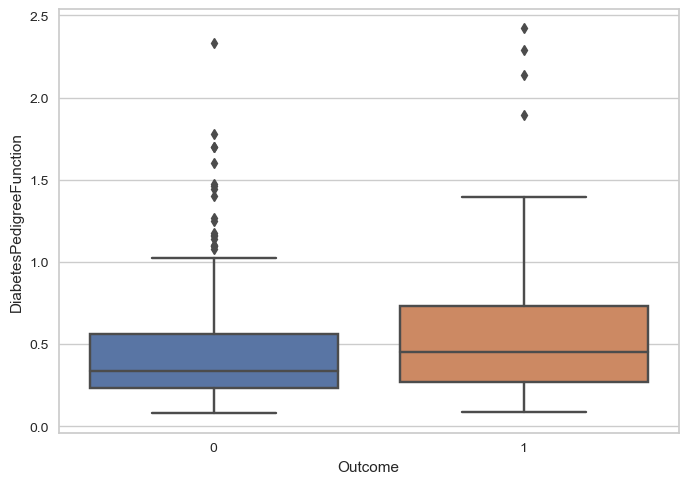

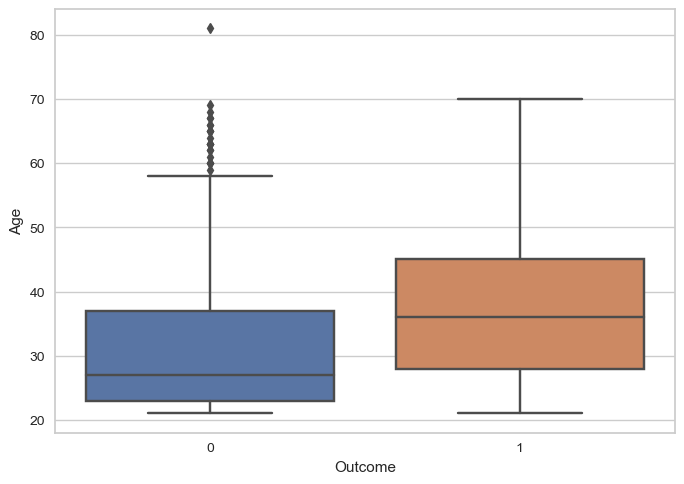

In [11]:
# variables grouped by the target
for col in predictors:
    plt.figure()
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.show()

Glucose level shows linear correlation with Diabetes.
The other linear correlations with the target appear insignificant. Note that we're using pearson correlation which works best comparing 2 continuous variables, and finds linear correlation only.

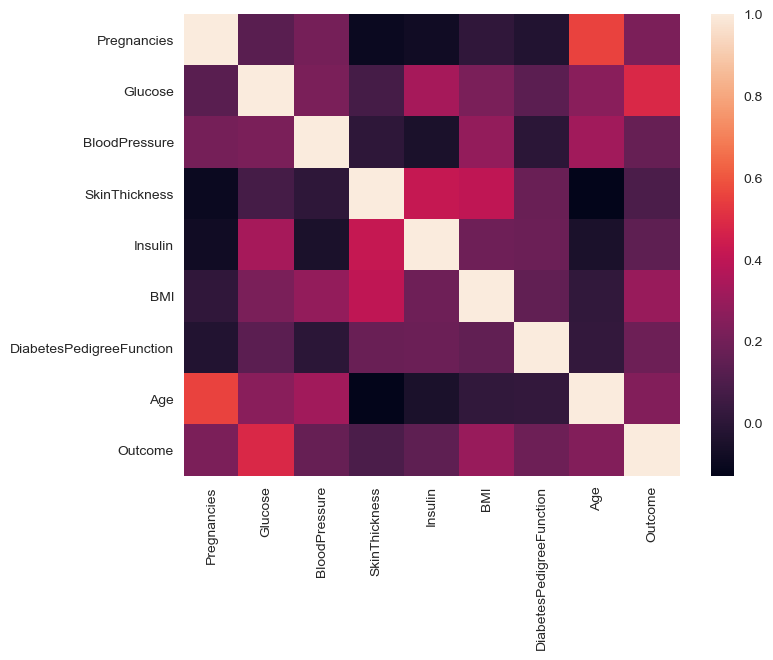

In [12]:
# correlation between different variables with the response variable
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr())

plt.show()

Pairplots, coloured by the target reveal if outcome classes are seperable when considering 2 features at a time. From this plot, it appears that a combination of Glucose and any other feature shows good separation between the outcome classes.  Based on this, I will try to add LDA projections as features in the feature selection process. Other variables show separability but generally less, such as BMI with Pregnancies, Skin thickness and Insulin.

<Figure size 800x550 with 0 Axes>

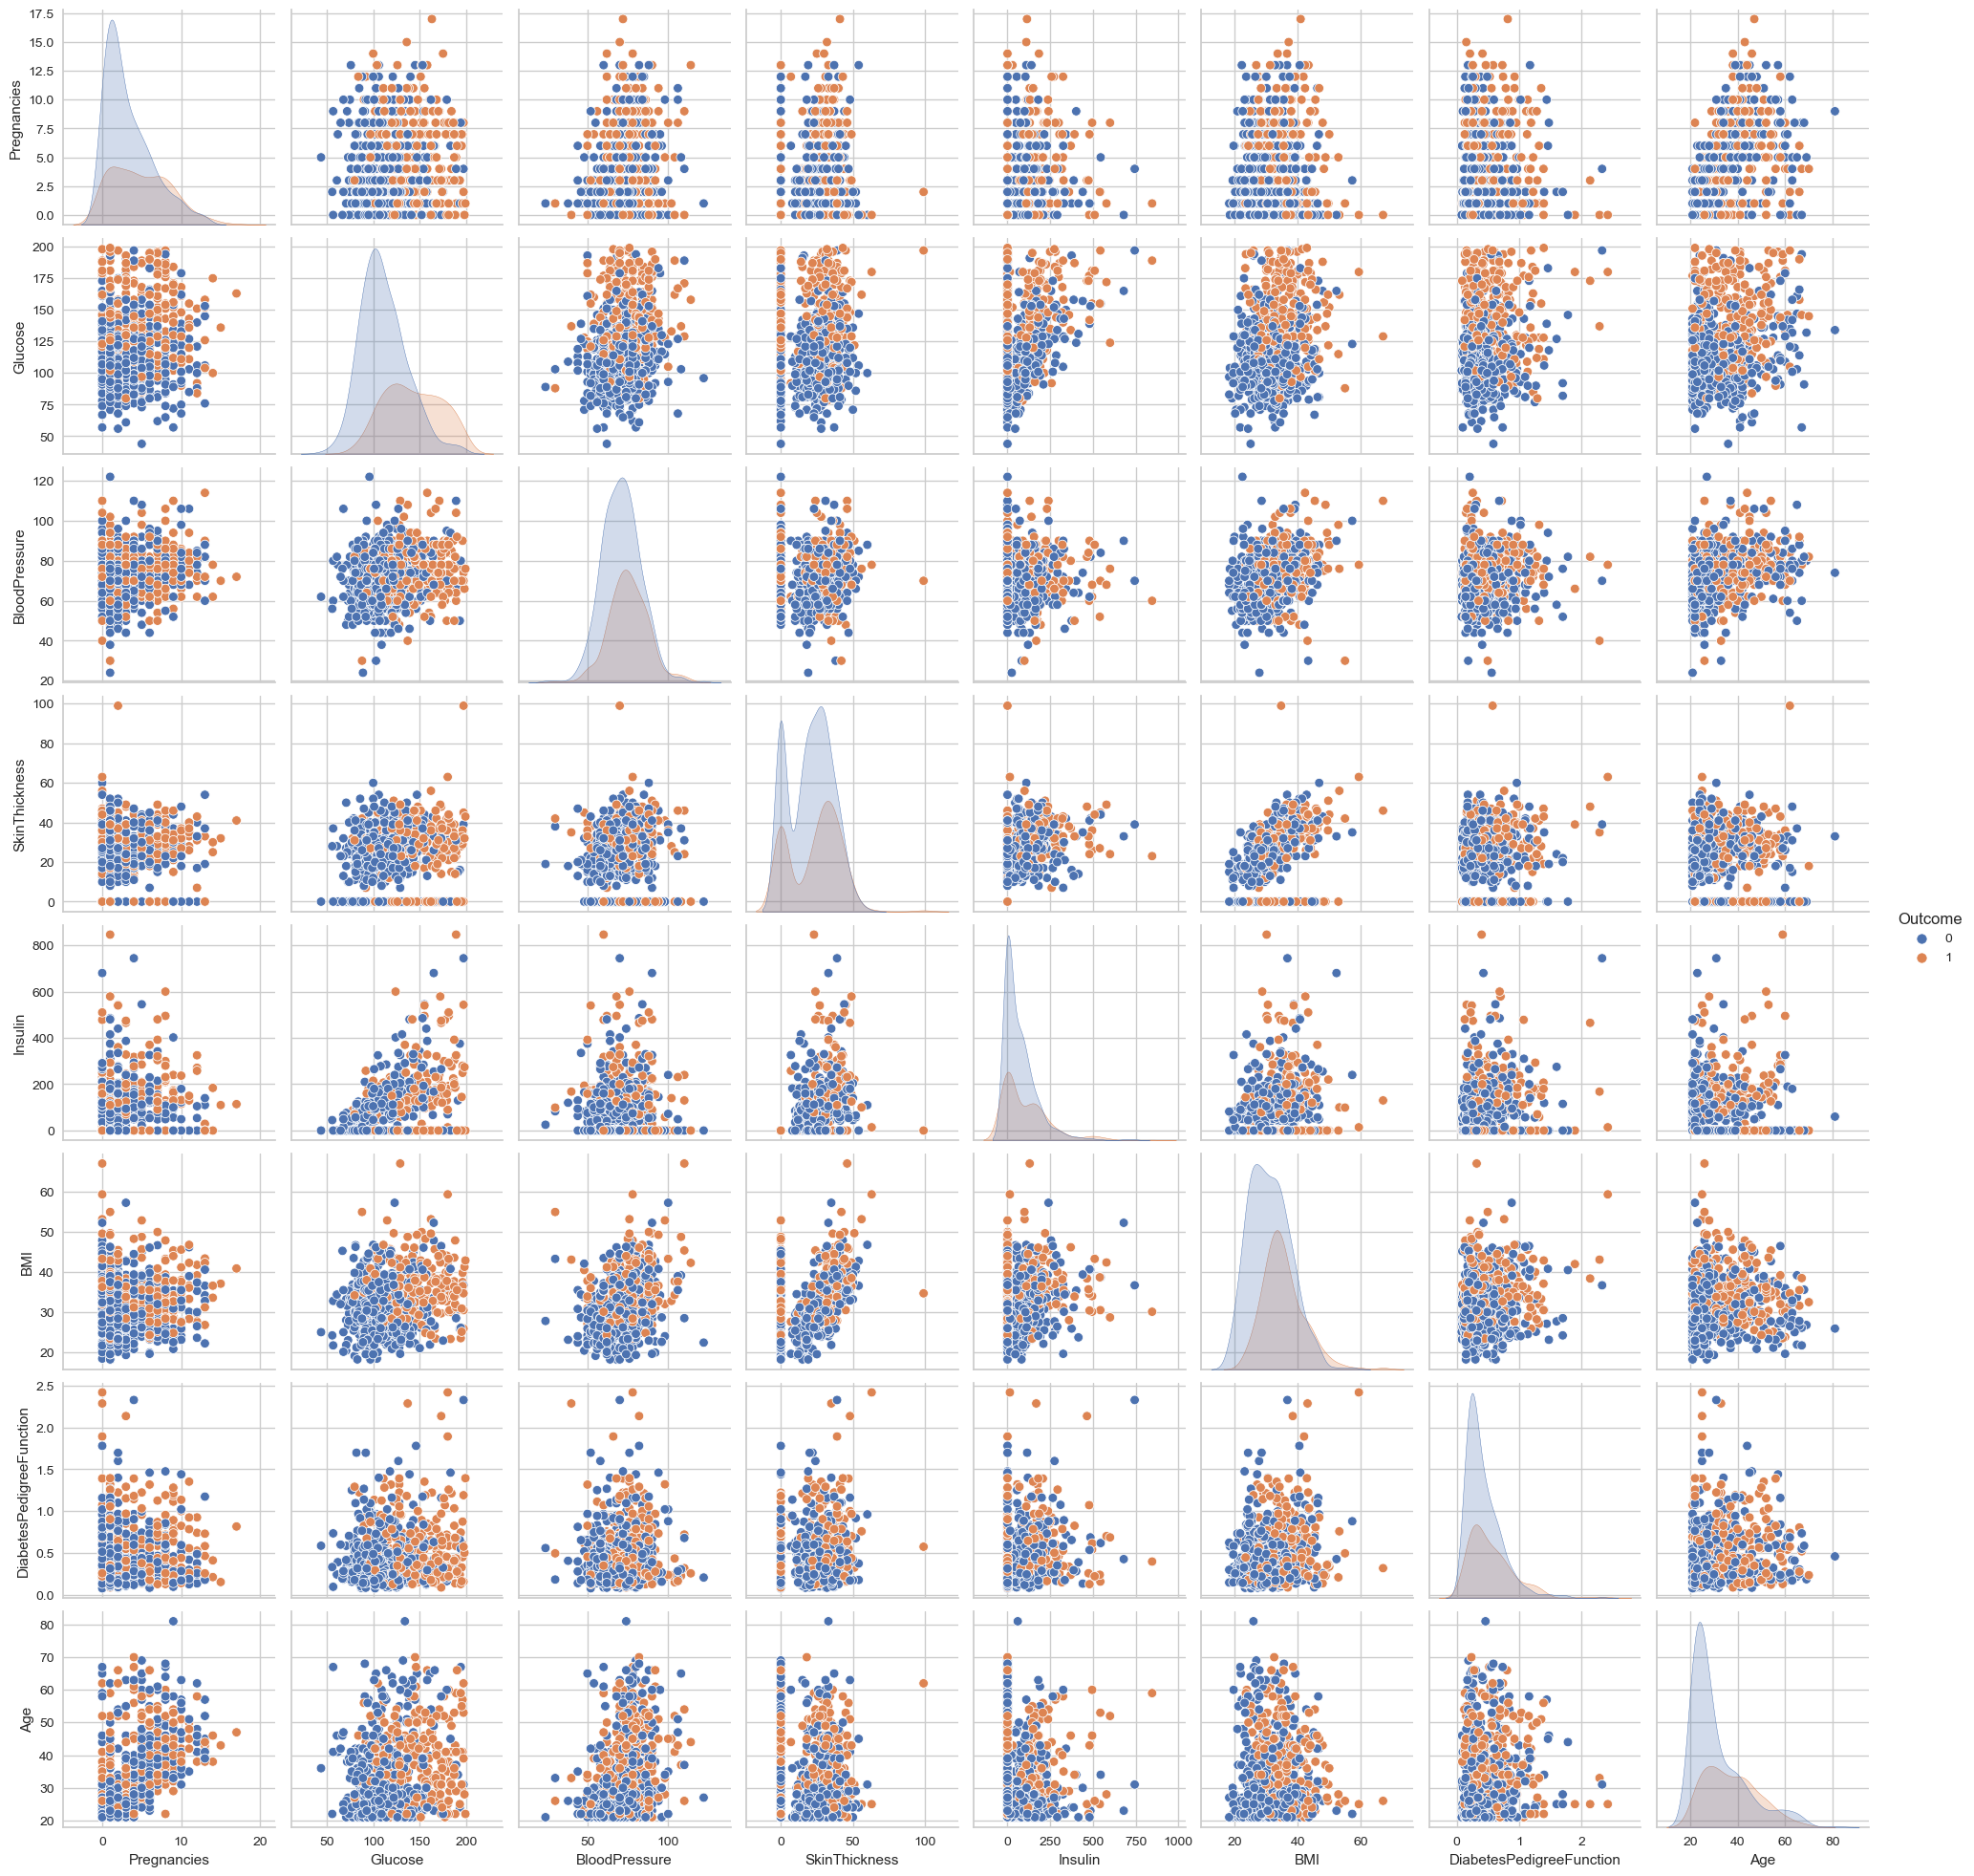

In [13]:
plt.figure()
sns.set_palette('deep')
sns.pairplot(df, hue=response)

plt.show()

### Feature Engineering

Here I tried adding some new features to the data based on transformations of the already existent features. These included ratio variables and LDA projections.

**Result:**
These features didn't significantly improve model performance of the random forest model with default parameters, so I left them out for the next section.

In [14]:
# helper function to compare model performance for different dataset configurations
# The function trains random forest classifier with default settings
def score_dataset(df, predictors=predictors, response='Outcome', folds=5):
    X = df[predictors]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    rf = RandomForestClassifier(random_state=seed)
    rf_accuracy = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    rf_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

    print('Random Forest Accuracy (Cross validated):', np.round(rf_accuracy.mean(), 4))
    print('Random Forest AUC (Cross Validated):', np.round(rf_auc.mean(), 4))
    
    

In [15]:
test_df = df.copy()

In [16]:
test_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
# adding ratio variables
test_df['Glucose_age_ratio'] = test_df['Glucose'] / test_df['Age']
test_df['Glucose_BMI_ratio'] = test_df['Glucose'] / test_df['BMI']
test_df['Glucose_bp_ratio'] = test_df['Glucose'] / test_df['BloodPressure']

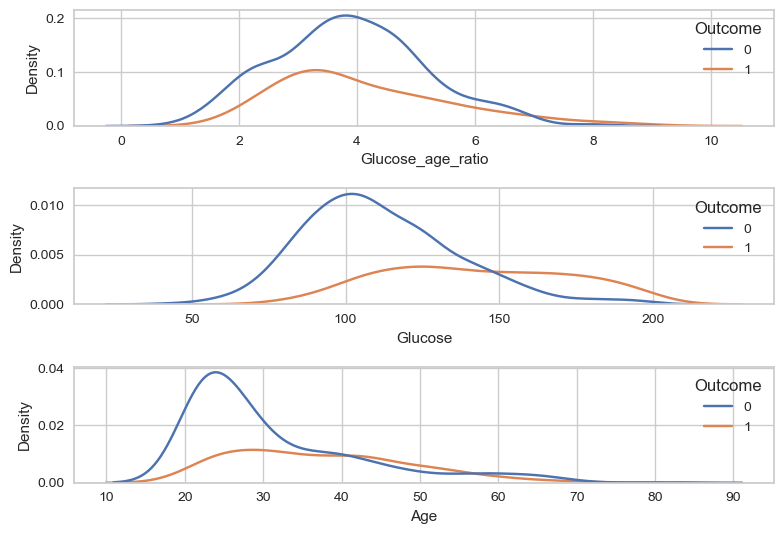

In [18]:
fig, axs = plt.subplots(3, 1)
sns.kdeplot(x='Glucose_age_ratio', hue='Outcome', data=test_df, ax=axs[0])
sns.kdeplot(x='Glucose', hue='Outcome', data=test_df, ax=axs[1])
sns.kdeplot(x='Age', hue='Outcome', data=test_df, ax=axs[2])

plt.tight_layout()

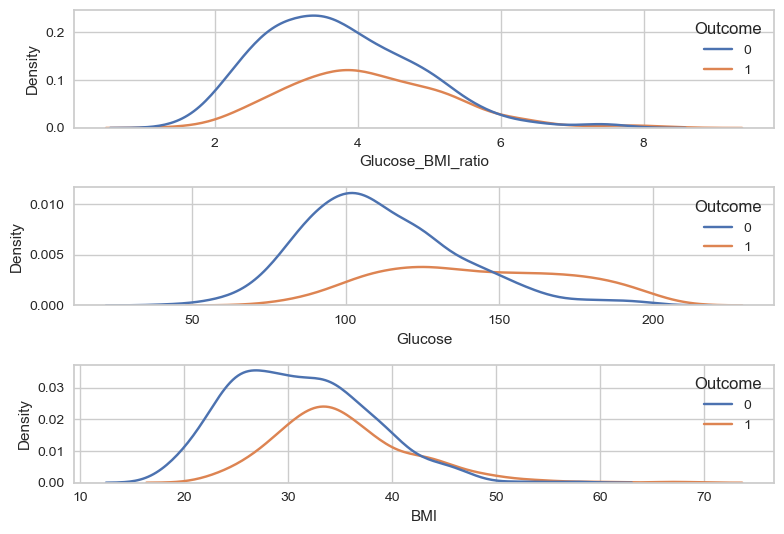

In [19]:
fig, axs = plt.subplots(3, 1)
sns.kdeplot(x='Glucose_BMI_ratio', hue='Outcome', data=test_df, ax=axs[0])
sns.kdeplot(x='Glucose', hue='Outcome', data=test_df, ax=axs[1])
sns.kdeplot(x='BMI', hue='Outcome', data=test_df, ax=axs[2])

plt.tight_layout()

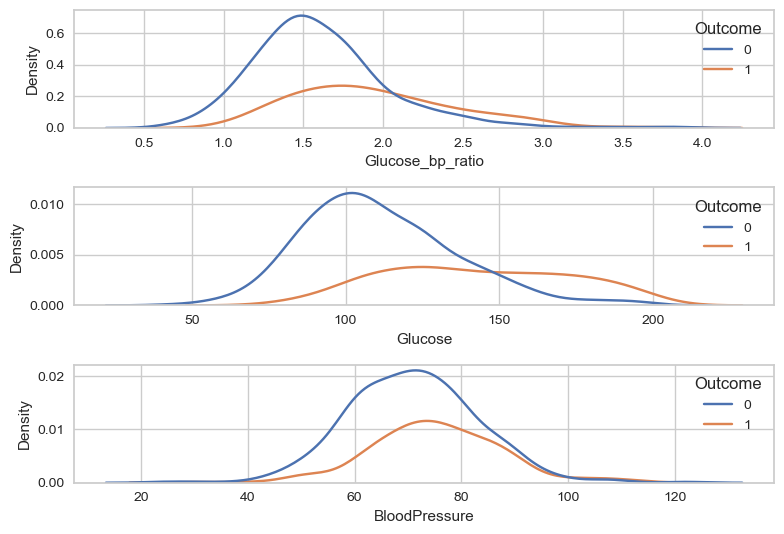

In [20]:
fig, axs = plt.subplots(3, 1)
sns.kdeplot(x='Glucose_bp_ratio', hue='Outcome', data=test_df, ax=axs[0])
sns.kdeplot(x='Glucose', hue='Outcome', data=test_df, ax=axs[1])
sns.kdeplot(x='BloodPressure', hue='Outcome', data=test_df, ax=axs[2])

plt.tight_layout()

In [21]:
predictors_fe1  = predictors + ['Glucose_age_ratio']
predictors_fe2 = predictors_fe1 + ['Glucose_bp_ratio']
predictors_fe3 = predictors_fe2 + ['Glucose_BMI_ratio']

In [22]:
rs = RobustScaler()
test_df[predictors_fe3] = rs.fit_transform(test_df[predictors_fe3])
test_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_age_ratio,Glucose_BMI_ratio,Glucose_bp_ratio
0,0.6,0.733728,0.000,0.333333,-0.367816,0.131868,0.648366,1.235294,1,-0.503815,0.418053,0.729315
1,-0.4,-0.757396,-0.375,0.151515,-0.367816,-0.637363,-0.073203,0.117647,0,-0.630030,-0.369779,-0.630410
2,1.0,1.562130,-0.500,-0.727273,-0.367816,-1.000000,0.766013,0.176471,1,1.092928,2.665257,2.153057
3,-0.4,-0.662722,-0.375,-0.030303,0.352490,-0.472527,-0.554248,-0.470588,0,0.235936,-0.388170,-0.523063
4,-0.6,0.473373,-2.000,0.333333,0.919540,1.175824,4.990850,0.235294,1,0.185824,-0.380747,3.154904


Comparing model performance with different ratio variables added. There was no significant performance gain from using these. Based on these figures, as well as the KDE plots above I decided to leave out the ratio variables.


In [23]:
# No ratio vars (Baseline)
score_dataset(test_df, predictors=predictors)

Random Forest Accuracy (Cross validated): 0.7422
Random Forest AUC (Cross Validated): 0.8147


In [24]:
score_dataset(test_df, predictors=predictors+['Glucose_bp_ratio'])

Random Forest Accuracy (Cross validated): 0.7477
Random Forest AUC (Cross Validated): 0.8096


In [25]:
score_dataset(test_df, predictors=predictors+['Glucose_BMI_ratio'])

Random Forest Accuracy (Cross validated): 0.7385
Random Forest AUC (Cross Validated): 0.8147


In [26]:
score_dataset(test_df, predictors=predictors+['Glucose_age_ratio'])

Random Forest Accuracy (Cross validated): 0.744
Random Forest AUC (Cross Validated): 0.8201


In [27]:
test_df = df.copy()

In [28]:
# applying LDA
X = test_df[predictors]
y = test_df[response]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train.shape, X_test.shape

((543, 8), (181, 8))

In [29]:
lda = LDA(n_components=1)

X_train['LDA_1'] = lda.fit_transform(X_train, y_train)
test_df['LDA_1'] = lda.transform(test_df[predictors])

<AxesSubplot:xlabel='LDA_1', ylabel='Count'>

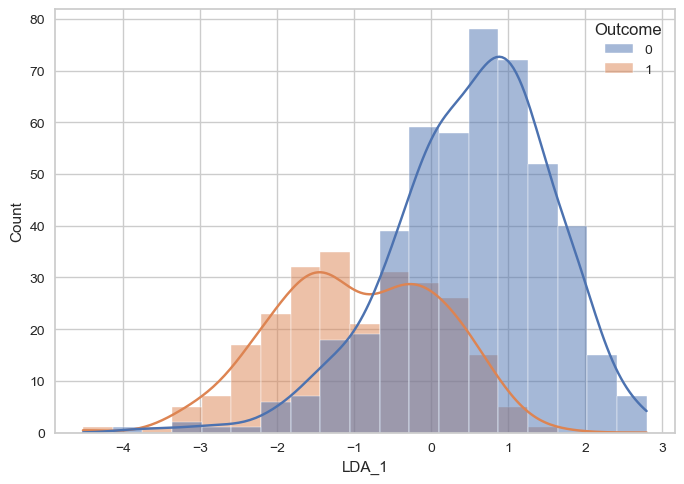

In [30]:
sns.histplot(x='LDA_1', data=test_df, hue=response, kde=True)

In [31]:
test_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LDA_1
0,6,148,72,35,0,33.6,0.627,50,1,-1.363734
1,1,85,66,29,0,26.6,0.351,31,0,1.794182
2,8,183,64,0,0,23.3,0.672,32,1,-1.626303
3,1,89,66,23,94,28.1,0.167,21,0,1.895033
4,0,137,40,35,168,43.1,2.288,33,1,-2.508196


LDA didn't cause any significant increase in performance so we will go ahead with the original variables.

In [32]:
print("Without LDA")
score_dataset(df)
print()
print("With LDA")
score_dataset(test_df, predictors=predictors+['LDA_1'])

Without LDA
Random Forest Accuracy (Cross validated): 0.7422
Random Forest AUC (Cross Validated): 0.815

With LDA
Random Forest Accuracy (Cross validated): 0.7367
Random Forest AUC (Cross Validated): 0.8074


### Modelling

The model evaluation was done as follows:
1. Split data into Train and Test
2. Using the Train dataset, perform k-fold cross validation to evaluate the models performance
3. After this, train model with the training dateset and predict the Test set and evaluate this models performance as the final metric scores.

Step 1 was done so that when we do hyperparameter tuning, the test set is hidden from the model to reduce overfitting. Step 2 was done to evaluate model performance during hyperparameter tuning. We used the same Train-test split to evaluate the default parameter models so that their performance on the test set is directly comparable to that of the tuned models.

Essentially, I used CV for hyperparameter tuning but a train-test split for the final evaluations of model performance.


In [34]:
predictors

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [35]:
X = df[predictors]
y = df[response]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train.shape, X_test.shape


((543, 8), (181, 8))

#### Random Forest



##### Default parameters

In [36]:
# default parameters
rf1 = RandomForestClassifier(random_state=seed)

In [37]:
# cross validation
rf1_accuracy = cross_val_score(rf1, X_train, y_train, cv=5, scoring='accuracy', verbose=0)
rf1_auc = cross_val_score(rf1, X_train, y_train, cv=5, scoring='roc_auc', verbose=0)
print('Random Forest Accuracy (Cross validated):', np.round(rf1_accuracy.mean(), 4))
print('Random Forest AUC (Cross Validated):', np.round(rf1_auc.mean(), 4))

Random Forest Accuracy (Cross validated): 0.7422
Random Forest AUC (Cross Validated): 0.815


In [38]:
# unseen test set
rf1.fit(X_train, y_train)
rf1_test_accuracy = accuracy_score(y_test, rf1.predict(X_test))
rf1_test_auc = roc_auc_score(y_test, rf1.predict(X_test))

print('Random Forest Accuracy (Test set):', np.round(rf1_test_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf1_test_auc.mean(), 4))


Random Forest Accuracy (Test set): 0.768
Random Forest AUC (Test set): 0.7206


##### Hyperparameter tuning

Here, we tune the following hyperparameters of the random forest model using RandomisedSearchCV:

- n_estimators  
- max_depth  
- min_sample_split
- min_samples_leaf  
- max_leaf_nodes  
- max_features




In [39]:
# creating random grid for running the randomised search

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num=10)]
max_depth = [int(x) for x in np.linspace(2, 50, num = 10)]
max_features = ['auto', 'sqrt']
min_samples_split = np.arange(2, 17, 2)
min_samples_leaf = [int(x) for x in np.arange(1, 11, 1)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 50, 10)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes
               }

random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'max_leaf_nodes': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50]}

In [40]:
rf2  =RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf2, param_distributions=random_grid, n_iter=100, cv=3, verbose=1, random_state=seed)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [2, 7, 12, 18, 23, 28, 34,
                                                      39, 44, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'max_leaf_nodes': [10, 14, 18, 23, 27,
                                                           32, 36, 41, 45, 50],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=1)

In [41]:
rf_random.best_params_

{'n_estimators': 311,
 'min_samples_split': 16,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 10,
 'max_features': 'sqrt',
 'max_depth': 39}

In [42]:
rf2_tuned = rf_random.best_estimator_
rf2_tuned_accuracy = accuracy_score(rf2_tuned.predict(X_test), y_test)
rf2_tuned_auc = roc_auc_score(rf2_tuned.predict(X_test), y_test)

In [43]:

print('Random Forest Accuracy (Test set):', np.round(rf2_tuned_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf2_tuned_auc.mean(), 4))


Random Forest Accuracy (Test set): 0.779
Random Forest AUC (Test set): 0.7414


In [44]:
# Compare performance to RF with default parameters
print('Random Forest Accuracy (Test set):', np.round(rf1_test_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf1_test_auc.mean(), 4))

Random Forest Accuracy (Test set): 0.768
Random Forest AUC (Test set): 0.7206


##### Extra testing

Here, I tried different numbers of trees and investigated the effect this has on the Accuracy and AUC metrics.

Result: Accuracy peaked at **75.69%** with 900 trees during cross validation. Although against the unseen test set, the model performed better with **78.45%** accuracy, **outperforming the hyperparamter tuned Random Forest model**.


In [45]:
# Trying different numbers of estimators

rf_accuracy_lst = []
rf_auc_lst = []

n_trees = np.arange(100, 2001, 100)

print("Cross validated metrics for different numbers of trees")
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=seed)

    rf_accuracy = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
    rf_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', verbose=0).mean()
    
    print("n-trees =", n,"| Accuracy:", np.round(rf_accuracy, 4),"| AUC:", np.round(rf_auc, 4))
    print("-"*100)


    rf_accuracy_lst.append(rf_accuracy)
    rf_auc_lst.append(rf_auc)



Cross validated metrics for different numbers of trees
n-trees = 100 | Accuracy: 0.7422 | AUC: 0.815
----------------------------------------------------------------------------------------------------
n-trees = 200 | Accuracy: 0.7348 | AUC: 0.8153
----------------------------------------------------------------------------------------------------
n-trees = 300 | Accuracy: 0.7495 | AUC: 0.8181
----------------------------------------------------------------------------------------------------
n-trees = 400 | Accuracy: 0.7514 | AUC: 0.8155
----------------------------------------------------------------------------------------------------
n-trees = 500 | Accuracy: 0.7514 | AUC: 0.8154
----------------------------------------------------------------------------------------------------
n-trees = 600 | Accuracy: 0.7477 | AUC: 0.8157
----------------------------------------------------------------------------------------------------
n-trees = 700 | Accuracy: 0.7532 | AUC: 0.8171
-----------

In [46]:

rf_scores = pd.DataFrame({'estimators': n_trees, 'accuracy': rf_accuracy_lst, 'auc': rf_auc_lst})
rf_scores.head()


,estimators,accuracy,auc
0,100,0.742168,0.815043
1,200,0.734794,0.815257
2,300,0.749507,0.818079
3,400,0.751359,0.815484
4,500,0.751376,0.815397


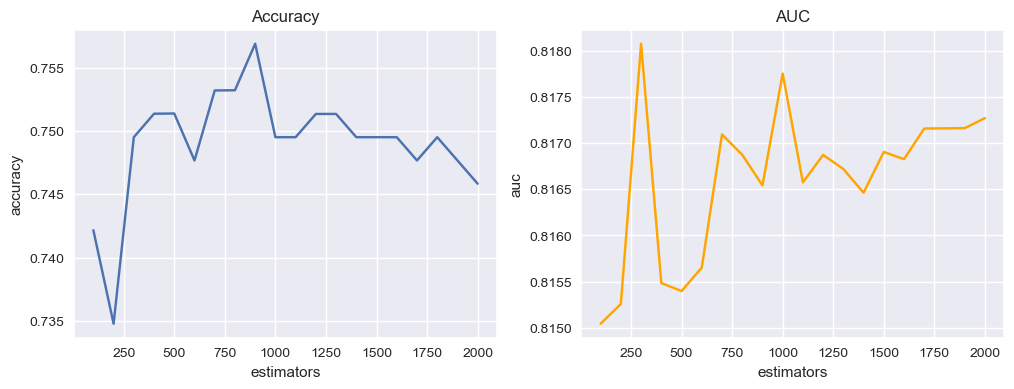

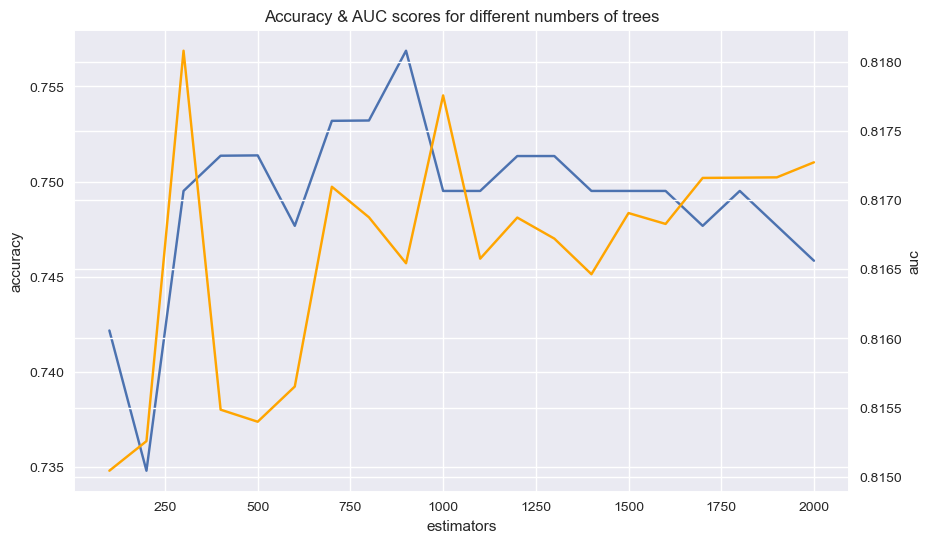

In [47]:
sns.set_style('darkgrid')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))


sns.lineplot(x='estimators', y='accuracy', data=rf_scores, ax=axs[0])
axs[0].set_title('Accuracy')

sns.lineplot(x='estimators', y='auc', data=rf_scores, ax=axs[1], color='orange')
axs[1].set_title('AUC')

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()


sns.lineplot(x='estimators', y='accuracy', data=rf_scores, ax=ax1)
sns.lineplot(x='estimators', y='auc', data=rf_scores, ax=ax2, color='orange')
plt.title('Accuracy & AUC scores for different numbers of trees')
plt.show()


In [48]:
trees = int(rf_scores.loc[np.argmax(a=rf_scores['accuracy']), ['estimators']])
trees

900

In [49]:
# Now testing RF model with best number of trees against the test set
rf3 = RandomForestClassifier(n_estimators=trees, random_state=seed)

rf3.fit(X_train, y_train)
rf3_test_accuracy = accuracy_score(y_test, rf3.predict(X_test))
rf3_test_auc = roc_auc_score(y_test, rf3.predict(X_test))

print('Random Forest Accuracy (Test set):', np.round(rf3_test_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf3_test_auc.mean(), 4))



Random Forest Accuracy (Test set): 0.7845
Random Forest AUC (Test set): 0.7428


#### AutoML

How it works:

**PyCaret** is one of the popular open-source libraries in python which facilitate AutoML (Automated machine learning). It is a low-code library which allows for users to easily automate machine learning workflows using a number of high-level functions. As long as the training data is read into a pandas data frame, and the test set is in another separate data frame, the rest can be done using PyCaret. The Pycaret workflow generalized to be able to handle classification, regression, clustering, and anomaly detection with the almost the exact same code. For this assignment, we used PyCaret’s AutoML framework for a classification task.

https://pycaret.readthedocs.io/en/latest/api/classification.html

Automated preprocessing:
The first step was to pass the training data through a preprocessing function, **“pycaret.classification.setup”**. This function does a sequence of preprocessing steps which are tweakable by overriding its default parameters. In our case, the “Pregnancies” variable was converted to categorical by the setup function’s type inferencing, but this was incorrect. To fix this, I just had to add the argument “numeric_features=[‘Pregnancies’]” in order to manually set the type for that variable. The function outputs a table containing details on the preprocessed data, such as the number of categorical features, and the missing-value imputation method used. **See the PyCaret documentation for a full list of arguments for the function.**

AutoML:
After running the preprocessing step, we can run the AutoML function, pycaret.classification.compare_models, which tries all the machine learning models available in the package using cross validation, ranks them in terms of several performance metrics, and outputs this as a table. The training time for each model (in seconds) is also featured on this table. The highest scores in terms of each metric are highlighted in the resulting table. The metrics are namely: Accuracy, AUC, Precision, Recall, F1, Kappa, and Matthews Correlation Coefficient. The model that performs best in terms of these metrics is returned by the function.


compare_models() is extremely useful, as it would usually take much more time and code to compare the performance of these algorithms at a classification task. Although this doesn’t give a full model diagnostic, it can give clear indication of which algorithms out-of-the-box perform best on our dataset. It also gives us a baseline for comparing to our hand-engineered machine learning models. There is a “fold” argument, which I used here, that defines the number of folds to use for a k-fold cross validation of the different modelling techniques. For a small training set (for example, ~600 rows like I used in this assignment), the function runs in reasonable time (~12 seconds for 10 folds) but for larger datasets it could become expensive to run. Note also that we’re given functionality to run compare_models() as a parallel process, using Spark for example.


Finally, once we select the model PyCaret is able to tune the hyperparameters of the model using pycaret.classification.tune_model. This function also has many optional arguments, but by default runs a random grid search using the sci-kit learn implementation. I inspected the result of hyperparameter tuning by printing the untuned and tuned models.





In [50]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train.shape, test.shape

((543, 9), (181, 9))

In [51]:
# preprocessing
clf = setup(data=train, target=response, session_id=seed, numeric_features=['Pregnancies'])

,Description,Value
0,session_id,42
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(543, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [64]:
# AutoML - model selection
bestmodel = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7763,0.8460,0.6416,0.7376,0.6809,0.5107,0.5178,0.7160
lda,Linear Discriminant Analysis,0.7684,0.8500,0.6207,0.7282,0.6660,0.4912,0.4978,0.0060
ridge,Ridge Classifier,0.7658,0.0000,0.6135,0.7264,0.6603,0.4843,0.4918,0.0060
nb,Naive Bayes,0.7632,0.8263,0.6204,0.7184,0.6614,0.4814,0.4880,0.0060
et,Extra Trees Classifier,0.7447,0.8143,0.5773,0.7017,0.6286,0.4371,0.4455,0.0620
rf,Random Forest Classifier,0.7395,0.8095,0.5628,0.6943,0.6159,0.4225,0.4321,0.0680
qda,Quadratic Discriminant Analysis,0.7395,0.8113,0.5850,0.6787,0.6251,0.4276,0.4327,0.0080
ada,Ada Boost Classifier,0.7368,0.7920,0.6549,0.6520,0.6471,0.4385,0.4437,0.0300
gbc,Gradient Boosting Classifier,0.7316,0.7922,0.6190,0.6542,0.6293,0.4202,0.4256,0.0300
lightgbm,Light Gradient Boosting Machine,0.7000,0.7871,0.5980,0.6130,0.5994,0.3610,0.3654,0.1500


In [59]:
# AutoML - tuning
final_model, tuner = tune_model(bestmodel, return_tuner=True)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7105,0.8274,0.6429,0.6000,0.6207,0.3871,0.3877
1,0.8684,0.9256,0.7143,0.9091,0.8000,0.7040,0.7154
2,0.8684,0.9583,0.7857,0.8462,0.8148,0.7130,0.7142
3,0.6579,0.7738,0.6429,0.5294,0.5806,0.2963,0.3003
4,0.9211,0.9286,0.8571,0.9231,0.8889,0.8278,0.8292
5,0.7632,0.8423,0.8571,0.6316,0.7273,0.5263,0.5455
6,0.6579,0.7470,0.5000,0.5385,0.5185,0.2538,0.2542
7,0.7895,0.8423,0.6429,0.7500,0.6923,0.5337,0.5374
8,0.7105,0.7652,0.7333,0.6111,0.6667,0.4146,0.4200


In [60]:
print(bestmodel)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [61]:
print(final_model)

LogisticRegression(C=2.214, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [62]:
fm_pred = predict_model(final_model, data=test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7348,0.8177,0.7091,0.5493,0.6190,0.4206,0.4287


In [63]:
bm_pred = predict_model(bestmodel, data=test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7735,0.8175,0.6182,0.6296,0.6239,0.4618,0.4619


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Label,Score
346,1,139,46,19,83,28.7,0.654,22,0,0,0.6365
553,1,88,62,24,44,29.9,0.422,23,0,0,0.9386
590,11,111,84,40,0,46.8,0.925,45,1,1,0.8832
36,11,138,76,0,0,33.2,0.420,35,0,1,0.6334
399,3,193,70,31,0,34.9,0.241,25,1,1,0.7639
...,...,...,...,...,...,...,...,...,...,...,...
319,6,194,78,0,0,23.5,0.129,59,1,1,0.7818
280,0,146,70,0,0,37.9,0.334,28,1,0,0.5358
418,1,83,68,0,0,18.2,0.624,27,0,0,0.9758
391,5,166,76,0,0,45.7,0.340,27,1,1,0.8483


In [58]:
# checking that sklearn metric matches the pycaret metric
np.round(accuracy_score(y_test, fm_pred.Label), 4)

0.7348

### Final Discussion (Comparing the two approaches)

#### Performance:

The results using Random Forest and AutoML are shown below. These metrics are based on predictions of the unseen test set:

| Method                    | Accuracy   | AUC        |
| ------------------------  | ---------- | ------     |
| Random Forest (Default)   | 0.7680     | 0.7206     |
| Random Forest (Tuned)     | 0.7790     | 0.7414     |
| Random Forest (Extra Test)| **0.7845** | 0.7428     |
| AutoML (Default)          | 0.7735     | 0.8175     |
| AutoML (Tuned)            | 0.7348     | **0.8177** |


Table 1, performance metrics for RF and AutoML models.

<br>

Using default parameters for both approaches, AutoML outperformed the Random Forest model. This was an expected result, as random forest is a a single machine learning technique, yet AutoML tries a wide variety of machine learning techniques. The **best performing model, selected by AutoML was Logistic Regression**.

In this case, **hyperparameter tuning didn't improve the AutoML model**. In fact, the accuracy of the AutoML tuned model suffers. Note that AUC is a more robust metric than accuracy (Ling, Huang and Zhang, 2003), and this remains around the same as the original AutoML (LR) model. In contrast, parameter tuning improved the Random Forest model. I performed an extra tuning test, adjusting only the number of trees in the RF model and achieved higher performance than the RandomisedSearchCV parameter tuned RF model (See "Extra testing").

Based on these results, it would appear that the AutoML and random forest models are almost on per with one another, although the AutoML model achieved higher AUC in general. Also, the results here seem to be sensitive to the test set. Since the dataset is small (~700 rows), the performance metrics fluctuate slightly based on the train-test-split. An alternative would've been to use nested cross validation for hyperparameter tuning and model evaluaiton rather than a train-test split for the final evaluation.

#### Overall:

PyCaret's AutoML implementation makes is very easy to build and compare machine learning models. It's default arguments allow for low-code solutions end-to-end, but it allowed me to make changes to the modelling process as I saw fit, from data preprocessing to hyperparameter tuning. AutoML automatically outputs performance metrics when comparing models or using models to make predictions, making for less code than I used in the hand-engineered random forest approach.

I think that the preprocessing options (in pycaret.classification.setup) for AutoML could be insufficient for more complex and/or untidy data. Although it has optional arguments for missing value imputation and type casting, I'd prefer to do any preprocessing prior to passing data into AutoML, as I would do using the hand-engineered approach also.

The hyperparameter tuning option for AutoML was convenient. I used the default parameters here, while defining an explicit search space for tuning the random forest model. Scikit-learn and Optuna, the two most popular packages for hyperpatameter tuning, are integrated into PyCaret.

A potential downside to using AutoML to select the algorithm to proceed with is that since it trains these models using the default parameters, so the ranking order is partially dependent on how suitable the default parameters are, and on the sensitivity of models to hyperparameter tuning. That being said, I believe AutoML is an incredible tool for quickly assessing where to start when approaching a predictive modelling task. I just wouldn't take the compare_models() results as the only decision factor without further analysis.



Bibliography:

Ling, C.X., Huang, J. and Zhang, H. (2003). AUC: A Better Measure than Accuracy in Comparing Learning Algorithms. [online] ResearchGate. Available at: https://www.researchgate.net/publication/221442229_AUC_A_Better_Measure_than_Accuracy_in_Comparing_Learning_Algorithms [Accessed 1 Oct. 2022].

‌
